In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import gennorm
from scipy.special import gamma as gamma_func

In [2]:
# ---------------------
# 1. Data Loading & Processing
# ---------------------
# Load the CSV file
df = pd.read_csv("../data/cleanv3_transform.csv")

In [32]:
# Filter out rows where 'INCZERO_ONE' or 'INCZERO_TWO' are equal to 1
df_filtered = df[(df['INCZERO_ONE'] != 1) & (df['INCZERO_TWO'] != 1)]

# Build the main dataframe with continuous target and predictors.
df_data = pd.DataFrame({
    "target": df_filtered["INCLOG_DELTA"],
})

continuous_features = ['INCWAGE', 'INCPER', 'EDUC', 'INCTOT', 'NCHILD', 'HEALTH', 'FTOTVAL', 'INCSS', 'AGE', 'INCSSI']
df_cont = df_filtered[continuous_features].copy()

# Append additional continuous features (columns starting with "occ_" or "ind_")
df_hccat = pd.concat([df_filtered.filter(regex="^(occ_|occly_|ind_|indly_)")], axis=1)

# One-hot encode categorical features and add them as predictors.
categorical_features = ['PENSION', 'NATIVITY', 'EMPSTAT', 'SCHLCOLL', 'FAMREL', 'RELATE', 'DIFFHEAR', 'FAMKIND', 'DISABWRK', 'MARST', 'SEX', 'DIFFANY', 'FTYPE', 'LABFORCE', 'MIGRATE1']
ohe = OneHotEncoder(sparse_output=False)
encoded_array = ohe.fit_transform(df_filtered[categorical_features])
encoded_col_names = ohe.get_feature_names_out(categorical_features)
df_cat = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_filtered.index)

df_data = pd.concat([df_data, df_cont, df_hccat, df_cat], axis=1)

# Split into training and validation sets.
full, test = train_test_split(df_data, test_size=0.2, random_state=42)

# Split into training and validation sets.
train, val = train_test_split(full, test_size=0.2, random_state=42)

In [33]:
# --------------------------
# Dataset
# --------------------------
class MyDataset(Dataset):
    def __init__(self, dataframe):
        # All columns except "target" are features.
        self.X = dataframe.drop(columns=["target"]).values.astype(np.float32)
        self.y = dataframe["target"].values.astype(np.float32)  # shape (N,)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --------------------------
# Model Definition
# --------------------------
class HierarchicalMDN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout_rate=0.2):
        """
        Constructs the hierarchical MDN model with dropout.
        Parameters:
           input_dim     : Dimension of input features.
           hidden_dim    : Size of hidden layers.
           dropout_rate  : Dropout rate for regularization.
        """
        super().__init__()
        
        # Shared feature extractor with dropout.
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate)
        )
        
        # Regime gating head: outputs a scalar, then sigmoid for ρ(x)
        self.regime_head = nn.Linear(hidden_dim, 1)
        
        # Positive-regime MDN head: outputs 6 values: 
        # 2 mixture logits, 2 shape (alpha) parameters, 2 scale (f) parameters.
        self.pos_head = nn.Linear(hidden_dim, 6)
        
        # Negative-regime MDN head: same structure as positive branch.
        self.neg_head = nn.Linear(hidden_dim, 6)
    
    def forward(self, x):
        h = self.shared(x)
        # Regime gating: probability for positive regime.
        regime_logit = self.regime_head(h)
        rho = torch.sigmoid(regime_logit)  # p(r = 1|x)
        
        # Positive branch:
        pos_out = self.pos_head(h)  # shape: (batch, 6)
        pos_mix_logits = pos_out[:, :2]  # first 2 entries for mixture weights
        p_pos_pi = torch.sigmoid(pos_mix_logits[:, 0]) 
        pos_pi = torch.stack([p_pos_pi, 1 - p_pos_pi], dim=1)  # ensure they sum to 1
        pos_alpha = F.softplus(pos_out[:, 2:4]) + 1e-3  # shape parameters (α); ensure > 0
        pos_scale = F.softplus(pos_out[:, 4:6]) + 1e-3    # scale parameters; ensure > 0
        
        # Negative branch:
        neg_out = self.neg_head(h)
        neg_mix_logits = neg_out[:, :2]
        p_neg_pi = torch.sigmoid(neg_mix_logits[:, 0]) 
        neg_pi = torch.stack([p_neg_pi, 1 - p_neg_pi], dim=1)
        neg_alpha = F.softplus(neg_out[:, 2:4]) + 1e-3
        neg_scale = F.softplus(neg_out[:, 4:6]) + 1e-3
        
        return {
            "rho": rho,               # shape: (batch, 1)
            "pos_pi": pos_pi,         # shape: (batch, 2)
            "pos_alpha": pos_alpha,   # shape: (batch, 2)
            "pos_scale": pos_scale,   # shape: (batch, 2)
            "neg_pi": neg_pi,         # shape: (batch, 2)
            "neg_alpha": neg_alpha,   # shape: (batch, 2)
            "neg_scale": neg_scale    # shape: (batch, 2)
        }
    
    def set_dropout_rate(self, new_rate):
        """
        Update the dropout probability for all dropout layers.
        Call this method to set dropout rate to 0 for a second training run.
        """
        for m in self.modules():
            if isinstance(m, nn.Dropout):
                m.p = new_rate

# --------------------------
# Gamma Density Functions
# --------------------------
def gamma_log_prob(y, alpha, scale, eps=1e-6):
    """
    Returns the log probability of y > 0 under a Gamma density:
      p(y|alpha, f) = [alpha^alpha / (Γ(alpha)*f^alpha)] * y^(alpha-1) * exp(-alpha*y/f)
    """
    y = y.unsqueeze(1)  # (batch,1)
    log_prob = (alpha * torch.log(alpha + eps)
                - torch.lgamma(alpha)
                - alpha * torch.log(scale + eps)
                + (alpha - 1) * torch.log(y + eps)
                - alpha * y / scale)
    return log_prob  # (batch,2)

def mirrored_gamma_log_prob(y, alpha, scale, eps=1e-6):
    """
    Returns the log probability of y < 0 under a mirrored Gamma density:
    Define t = -y > 0.
      p(y|alpha, f) = [alpha^alpha / (Γ(alpha)*f^alpha)] * (-y)^(alpha-1) * exp(alpha*y/f)
    """
    y = y.unsqueeze(1)
    log_prob = (alpha * torch.log(alpha + eps)
                - torch.lgamma(alpha)
                - alpha * torch.log(scale + eps)
                + (alpha - 1) * torch.log(-y + eps)
                + alpha * y / scale)
    return log_prob  # (batch,2)

# --------------------------
# Negative Log-Likelihood Loss
# --------------------------
def negative_log_likelihood(outputs, y):
    """
    Computes the negative log likelihood loss. For each sample:
      For y ≥ 0:
        log p = log(ρ(x)) + log[ π₊(x)*p₊₁(y|x) + (1-π₊(x))*p₊₂(y|x) ]
      For y < 0:
        log p = log(1-ρ(x)) + log[ π₋(x)*p₋₁(y|x) + (1-π₋(x))*p₋₂(y|x) ]
    """
    batch_size = y.shape[0]
    rho = outputs["rho"].squeeze(1)    # (batch,)
    pos_pi = outputs["pos_pi"]         # (batch,2)
    pos_alpha = outputs["pos_alpha"]   # (batch,2)
    pos_scale = outputs["pos_scale"]   # (batch,2)
    neg_pi = outputs["neg_pi"]         # (batch,2)
    neg_alpha = outputs["neg_alpha"]   # (batch,2)
    neg_scale = outputs["neg_scale"]   # (batch,2)
    
    eps = 1e-6
    # Boolean masks for positive and negative targets.
    pos_mask = (y >= 0)
    neg_mask = (y < 0)
    
    total_nll = 0.0
    # Process positive targets
    if pos_mask.sum() > 0:
        y_pos = y[pos_mask]
        log_p_pos = gamma_log_prob(y_pos, pos_alpha[pos_mask], pos_scale[pos_mask])
        weighted_pos = (pos_pi[pos_mask] * torch.exp(log_p_pos)).sum(dim=1)  # mixture summation
        log_prob_pos = torch.log(rho[pos_mask] + eps) + torch.log(weighted_pos + eps)
        total_nll += -log_prob_pos.sum()
    
    # Process negative targets
    if neg_mask.sum() > 0:
        y_neg = y[neg_mask]
        log_p_neg = mirrored_gamma_log_prob(y_neg, neg_alpha[neg_mask], neg_scale[neg_mask])
        weighted_neg = (neg_pi[neg_mask] * torch.exp(log_p_neg)).sum(dim=1)
        log_prob_neg = torch.log(1 - rho[neg_mask] + eps) + torch.log(weighted_neg + eps)
        total_nll += -log_prob_neg.sum()
        
    return total_nll / batch_size

# --------------------------
# Training Function with Early Stopping
# --------------------------
def train_model(model, train_loader, val_loader, n_epochs=100, lr=1e-3, patience=10, device="cpu"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    best_val_loss = float("inf")
    early_stop_counter = 0
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = negative_log_likelihood(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            
        train_loss = train_loss / len(train_loader.dataset)
        
        # Evaluate on validation set.
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                outputs = model(X_val)
                loss = negative_log_likelihood(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Early stopping based on validation loss.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            # Optionally, save the best model.
            best_model_state = model.state_dict()
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Validation loss did not improve for {} epochs. Early stopping.".format(patience))
                model.load_state_dict(best_model_state)
                break

# --------------------------
# Evaluation
# --------------------------

# Function to compute average loss over a DataLoader
def compute_average_loss(model, dataloader, device="cpu"):
    total_loss = 0.0
    total_samples = 0
    model.eval()  # ensure the model is in evaluation mode
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            # negative_log_likelihood is assumed to be defined elsewhere
            loss = negative_log_likelihood(outputs, y_batch)
            # Multiply by batch size to accumulate the total loss
            total_loss += loss * X_batch.size(0)
            total_samples += X_batch.size(0)
    avg_loss = total_loss / total_samples
    return avg_loss

def predict(model, dataloader, device="cpu"):
    """
    Compute predictions for the dataset in dataloader using the current model.
    For each sample, the predicted target is computed as:
        pred = ρ(x) * (∑[pos_pi * pos_scale]) + (1 - ρ(x)) * ( - ∑[neg_pi * neg_scale] )
    """
    model.eval()
    all_preds = []
    all_actual = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            # Expected value for the positive branch: weighted average of pos_scale using pos_pi
            pos_pred = (outputs["pos_pi"] * outputs["pos_scale"]).sum(dim=1)
            # Expected value for the negative branch: weighted average of neg_scale (with a minus sign)
            neg_pred = - (outputs["neg_pi"] * outputs["neg_scale"]).sum(dim=1)
            # Combine predictions via the gating probability ρ (squeezed to remove the trailing dimension)
            rho = outputs["rho"].squeeze(1)
            preds = rho * pos_pred + (1 - rho) * neg_pred
            all_preds.append(preds.detach().cpu().numpy())
            all_actual.append(y_batch.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_actual = np.concatenate(all_actual)
    return all_preds, all_actual

In [ ]:
# # Assume df_data is your DataFrame with features and "target".
# dataset = MyDataset(df_data)

# # Use 80% for training and 20% for validation.
# # Set your desired seed here
# seed = 86
# generator = torch.Generator().manual_seed(seed)

# val_size = int(0.2 * len(dataset))
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# input_dim = dataset.X.shape[1]
# # model = HierarchicalMDN(input_dim, hidden_dim=128, dropout_p=0.2)

In [38]:
# Assume df_data is your dataframe and MyDataset is your custom dataset class.
dataset = MyDataset(df_data)

# Create a list (or array) of indices equal to the length of your dataset.
indices = np.arange(len(dataset))

# Use train_test_split to split the indices into training (80%) and validation (20%).
full_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)

train_indices, val_indices = train_test_split(
    full_indices, test_size=0.2, random_state=42, shuffle=True
)

# Create Subset datasets that maintain the same data structure.
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

input_dim = dataset.X.shape[1]

In [ ]:
# Assume input_dim is known, and train_loader/val_loader are already defined.
device = "cuda" if torch.cuda.is_available() else "cpu"
initial_dropout = 0.4

# Instantiate and train the model.
model = HierarchicalMDN(input_dim, hidden_dim=512, dropout_rate=initial_dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# First training run: Train with dropout
model.set_dropout_rate(0.4)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs_phase1 = 100
patience = 10
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(n_epochs_phase1):
    model.train()
    # ... training loop on train_loader (similar to earlier code) ...
    # Assume we compute train_loss and also compute val_loss on val_loader.
    
    # (Pseudo-code for training)
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = negative_log_likelihood(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    
    # Validation loss evaluation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = negative_log_likelihood(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'nn_val_temp.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping activated.")
            model.load_state_dict(best_model_state)
            break

# Load the best model weights from file "best_model.pth"
best_model_state = torch.load("nn_val_temp.pth", map_location=device)
model.load_state_dict(best_model_state)
print("Best model loaded from file based on lowest validation loss.")

# Compute final losses for confirmation.
final_train_loss = compute_average_loss(model, train_loader, device=device)
final_val_loss = compute_average_loss(model, val_loader, device=device)
print("Final Training Loss: {:.4f}".format(final_train_loss))
print("Final Validation Loss: {:.4f}".format(final_val_loss))

# Optionally, save the best model for Phase 1 if desired.
torch.save(model.state_dict(), "best_model_phase1.pth")

Epoch 1: Train loss: 0.1245, Val loss: 0.0675
Epoch 2: Train loss: 0.0735, Val loss: 0.0535
Epoch 3: Train loss: 0.0618, Val loss: 0.0441
Epoch 4: Train loss: 0.0549, Val loss: 0.0397
Epoch 5: Train loss: 0.0489, Val loss: 0.0362
Epoch 6: Train loss: 0.0459, Val loss: 0.0345
Epoch 7: Train loss: 0.0422, Val loss: 0.0363
Epoch 8: Train loss: 0.0394, Val loss: 0.0294
Epoch 9: Train loss: 0.0373, Val loss: 0.0294
Epoch 10: Train loss: 0.0341, Val loss: 0.0267
Epoch 11: Train loss: 0.0321, Val loss: 0.0269
Epoch 12: Train loss: 0.0304, Val loss: 0.0255
Epoch 13: Train loss: 0.0283, Val loss: 0.0240
Epoch 14: Train loss: 0.0273, Val loss: 0.0241
Epoch 15: Train loss: 0.0256, Val loss: 0.0233
Epoch 16: Train loss: 0.0232, Val loss: 0.0222
Epoch 17: Train loss: 0.0223, Val loss: 0.0220
Epoch 18: Train loss: 0.0208, Val loss: 0.0216
Epoch 19: Train loss: 0.0198, Val loss: 0.0204
Epoch 20: Train loss: 0.0177, Val loss: 0.0202
Epoch 21: Train loss: 0.0171, Val loss: 0.0190
Epoch 22: Train loss: 

In [54]:
# Compute training loss.
model.train()  # set model to training mode (if needed for dropout, BN, etc.)
train_loss = compute_average_loss(model, train_loader, device=device)

# Compute validation loss.
val_loss = compute_average_loss(model, val_loader, device=device)

print("Training Loss: {:.4f}".format(train_loss))
print("Validation Loss: {:.4f}".format(val_loss))

Training Loss: -0.0276
Validation Loss: 0.0137


In [55]:
# Save the best model from Phase 1.
torch.save(model.state_dict(), "nn_2l512drop40_m027_137.pth")

In [177]:
best_model_state = torch.load("nn_val_temp.pth", map_location=device)
model.load_state_dict(best_model_state)

<All keys matched successfully>

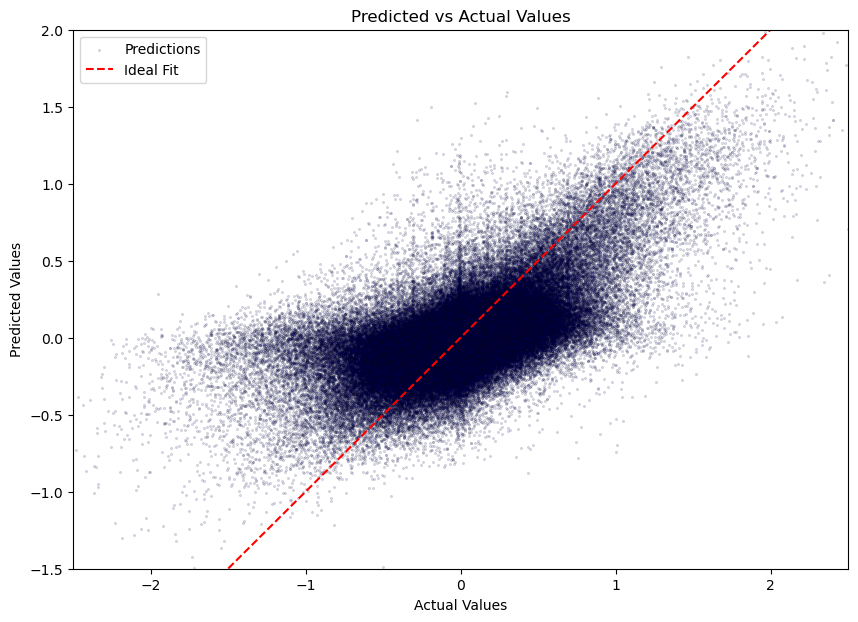

Mean Absolute Error (MAE): 0.20283296704292297


In [56]:
# Assume that 'val_loader' is your validation DataLoader and 'device' is defined.
y_pred_train, y_train = predict(model, train_loader, device=device)

# Plot predicted vs. actual values:
plt.figure(figsize=(10, 7))
plt.scatter(y_train, y_pred_train, c="darkblue", alpha=0.15, edgecolors="black", linewidth=0.5, s=2.5, label="Predictions")
# Plot an ideal 45-degree line (y=x) for reference.
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label="Ideal Fit")
plt.xlim(-2.5, 2.5)
plt.ylim(-1.5, 2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

# Compute the mean absolute error.
mae = mean_absolute_error(y_train, y_pred_train)
print("Mean Absolute Error (MAE):", mae)

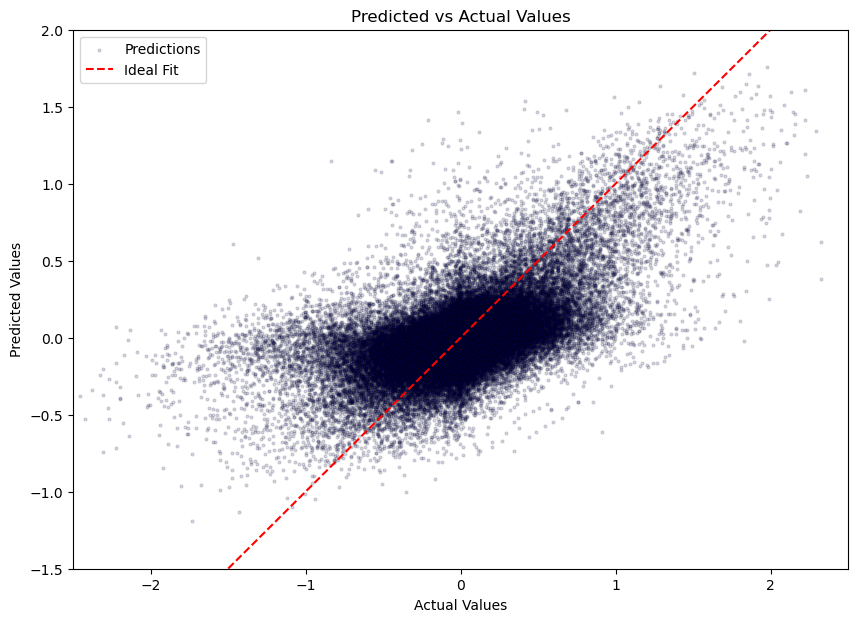

Mean Absolute Error (MAE): 0.20782291889190674


In [57]:
# Now predict on the training data (or on a held-out test set if available)
y_pred_test, y_test = predict(model, test_loader, device=device)

# Plot predicted vs. actual values:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred_test, c="darkblue", alpha=0.15, edgecolors="black", linewidth=0.89, s=4.47, label="Predictions")
# Plot an ideal 45-degree line (y=x) for reference.
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlim(-2.5, 2.5)
plt.ylim(-1.5, 2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

# Compute the mean absolute error.
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

Fitted parameters:
Shape (beta): 0.9122894319208124
Location (mu): 0.013924668570979817
Scale (alpha): 0.17577803880130283


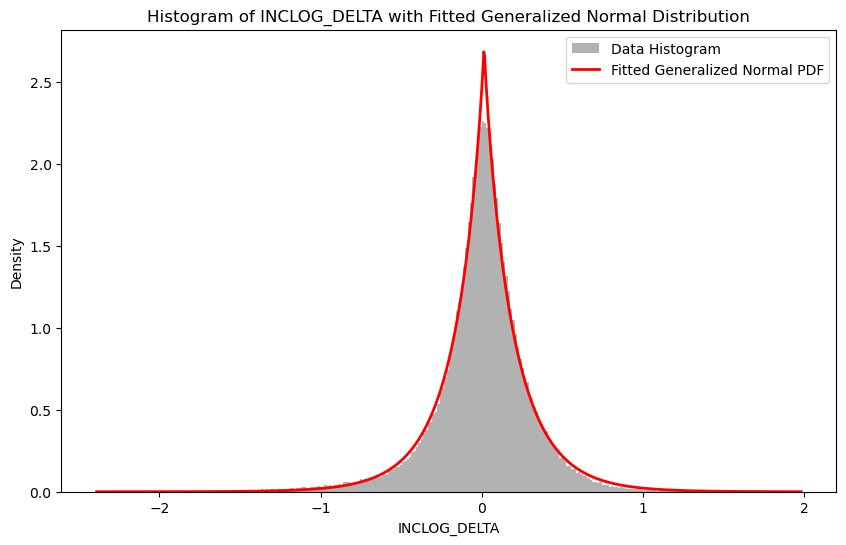

In [ ]:
# Assume df_data is your DataFrame and it contains the column "INCLOG_DELTA"
# Remove any missing values and get the data as a numpy array
data = y_train - y_pred_train

# Fit the generalized normal distribution to the data.
# The fit function returns the shape parameter (often called beta),
# as well as the location (mu) and scale (alpha) parameters.
shape, loc, scale = gennorm.fit(data)
print("Fitted parameters:")
print("Shape (beta):", shape)
print("Location (mu):", loc)
print("Scale (alpha):", scale)

alpha_fit = scale

# Generate a sequence of x values over the range of the data to later evaluate the PDF.
x = np.linspace(data.min(), data.max(), 1000)
pdf_values = gennorm.pdf(x, shape, loc=loc, scale=scale)

# Plot the density histogram and the fitted PDF.
plt.figure(figsize=(10, 6))
plt.hist(data, bins=300, density=True, alpha=0.6, color='gray', label='Data Histogram')
plt.plot(x, pdf_values, 'r-', lw=2, label='Fitted Generalized Normal PDF')
plt.xlabel('INCLOG_DELTA')
plt.ylabel('Density')
plt.title('Histogram of INCLOG_DELTA with Fitted Generalized Normal Distribution')
plt.legend()
plt.show()

Selected INCPER values and targets:
Sample 1 INCPER: -1.300366093386219  Actual target: 0.503042759
Sample 2 INCPER: -5.4850591253993016e-05  Actual target: 0.065885468
Sample 3 INCPER: 1.6500281870546134  Actual target: -0.882262696


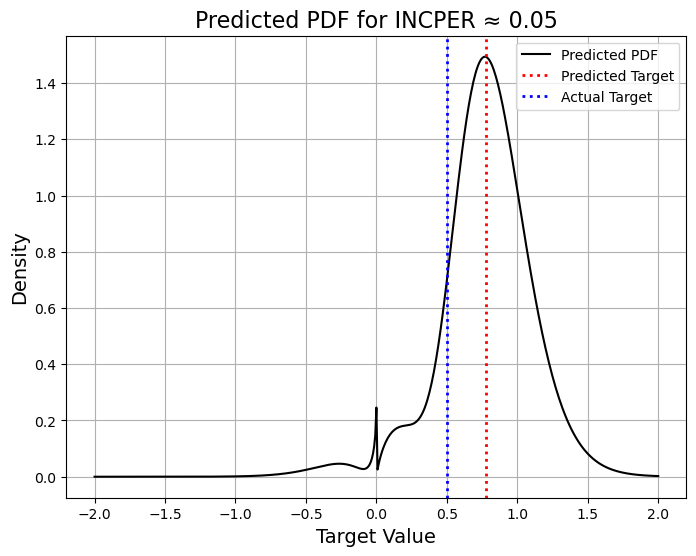

C:\Users\nickb\AppData\Local\Temp\ipykernel_35380\2197424699.py:13: RuntimeWarning: divide by zero encountered in power
  return (alpha**alpha / (gamma_func(alpha) * scale**alpha)) * (y**(alpha - 1)) * np.exp(-alpha*y/scale + eps)


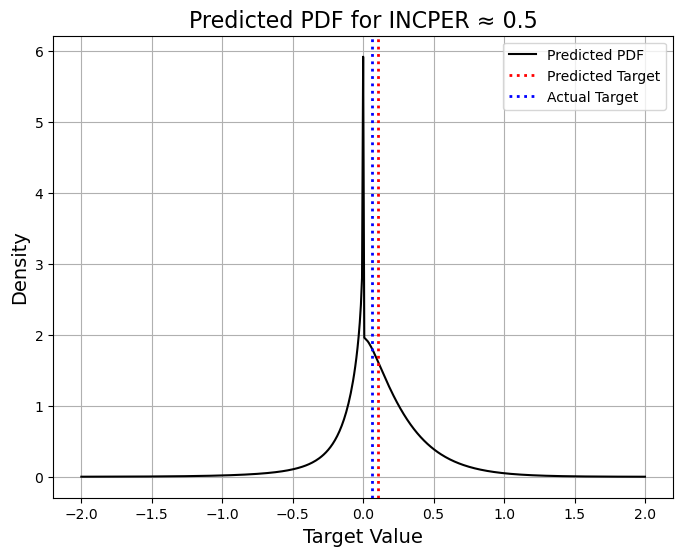

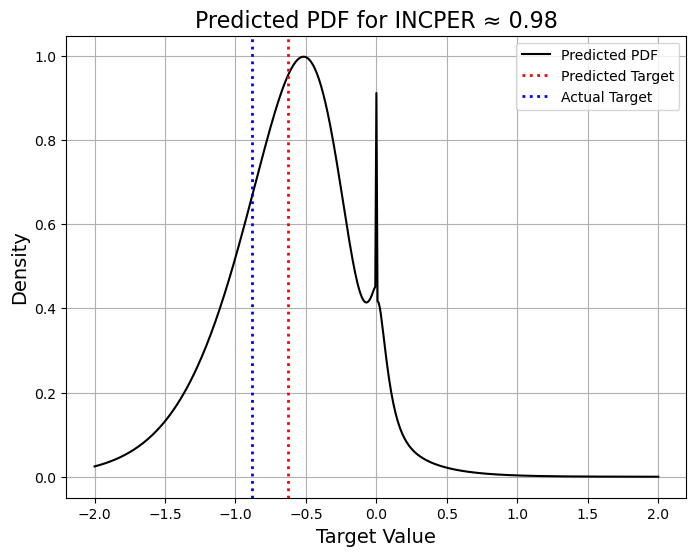

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.special import gamma as gamma_func
import pandas as pd

# --- Helper functions to compute density values ---
def gamma_pdf(y, alpha, scale, eps=1e-8):
    """
    Compute Gamma pdf for y > 0.
    pdf(y; alpha, scale) = [alpha^alpha/(Γ(alpha)*scale^alpha)] * y^(alpha-1) * exp(-alpha*y/scale)
    """
    return (alpha**alpha / (gamma_func(alpha) * scale**alpha)) * (y**(alpha - 1)) * np.exp(-alpha*y/scale + eps)

def mirrored_gamma_pdf(y, alpha, scale, eps=1e-8):
    """
    Compute mirrored Gamma pdf for y < 0.
    Define t = -y, then pdf(y; alpha, scale) = [alpha^alpha/(Γ(alpha)*scale^alpha)] * t^(alpha-1) * exp(alpha*y/scale)
    """
    return (alpha**alpha / (gamma_func(alpha) * scale**alpha)) * ((-y)**(alpha - 1)) * np.exp(alpha*y/scale + eps)

# --- Extended plot function that adds vertical lines ---
def plot_pdf_for_instance_with_targets(model, x_sample, actual_target, device, title=""):
    """
    For a given sample instance x_sample (shape [1, input_dim]) and its actual target value,
    evaluate the predicted probability density function over a grid.
    Then, compute the predicted target value and add vertical dotted lines for both predicted
    and actual target values on the plot.

    Parameters:
      model         : trained model.
      x_sample      : torch tensor input of shape [1, input_dim].
      actual_target : float, the ground-truth target value for this instance.
      device        : device string, e.g., "cuda" or "cpu".
      title         : plot title.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(x_sample.to(device))
        # Extract outputs and squeeze out batch dimension.
        rho = outputs["rho"].squeeze().item()              # scalar gating probability
        pos_pi = outputs["pos_pi"].squeeze()                 # shape: (2,)
        pos_alpha = outputs["pos_alpha"].squeeze()           # shape: (2,)
        pos_scale = outputs["pos_scale"].squeeze()           # shape: (2,)
        neg_pi = outputs["neg_pi"].squeeze()                 # shape: (2,)
        neg_alpha = outputs["neg_alpha"].squeeze()           # shape: (2,)
        neg_scale = outputs["neg_scale"].squeeze()           # shape: (2,)

    # --- Compute predicted target value ---
    # For the positive branch, expected target = weighted average of scale outputs.
    pos_pred = pos_pi[0].item()*pos_scale[0].item() + pos_pi[1].item()*pos_scale[1].item()
    # For the negative branch, expected target = negative weighted average of scale outputs.
    neg_pred = - (neg_pi[0].item()*neg_scale[0].item() + neg_pi[1].item()*neg_scale[1].item())
    # Final predicted target value is weighted by the gating probability.
    predicted_target = rho * pos_pred + (1 - rho) * neg_pred

    # --- Evaluate predicted PDF over a grid of y-values ---
    y_vals = np.linspace(-2, 2, 501)   # 801 points so that 0 is included exactly
    pdf_vals = np.zeros_like(y_vals)

    # Positive branch: for y >= 0.
    mask_pos = y_vals >= 0
    if np.any(mask_pos):
        y_pos = y_vals[mask_pos]
        # Here we use pos_pi[0] for the weight of first component, and (1 - pos_pi[0]) for second.
        pos_pdf = ( pos_pi[0].item() * gamma_pdf(y_pos, pos_alpha[0].item(), pos_scale[0].item()) +
                    (1 - pos_pi[0].item()) * gamma_pdf(y_pos, pos_alpha[1].item(), pos_scale[1].item()) )
        pdf_vals[mask_pos] = rho * pos_pdf

    # Negative branch: for y < 0.
    mask_neg = y_vals < 0
    if np.any(mask_neg):
        y_neg = y_vals[mask_neg]
        neg_pdf = ( neg_pi[0].item() * mirrored_gamma_pdf(y_neg, neg_alpha[0].item(), neg_scale[0].item()) +
                    (1 - neg_pi[0].item()) * mirrored_gamma_pdf(y_neg, neg_alpha[1].item(), neg_scale[1].item()) )
        pdf_vals[mask_neg] = (1 - rho) * neg_pdf

    # --- Patch density at 0: take weighted average from values near zero.
    epsilon = 1e-3
    pos_pdf_zero = ( pos_pi[0].item() * gamma_pdf(np.array([epsilon]), pos_alpha[0].item(), pos_scale[0].item()) +
                     (1 - pos_pi[0].item()) * gamma_pdf(np.array([epsilon]), pos_alpha[1].item(), pos_scale[1].item()) )
    neg_pdf_zero = ( neg_pi[0].item() * mirrored_gamma_pdf(np.array([-epsilon]), neg_alpha[0].item(), neg_scale[0].item()) +
                     (1 - neg_pi[0].item()) * mirrored_gamma_pdf(np.array([-epsilon]), neg_alpha[1].item(), neg_scale[1].item()) )
    pdf_at_zero = rho * pos_pdf_zero[0] + (1 - rho) * neg_pdf_zero[0]
    idx_zero = np.argmin(np.abs(y_vals))
    pdf_vals[idx_zero] = pdf_at_zero

    # --- Plot the PDF ---
    plt.figure(figsize=(8, 6))
    plt.plot(y_vals, pdf_vals, label="Predicted PDF", color="k")
    # Add vertical dotted line for predicted target value.
    plt.axvline(x=predicted_target, color="r", linestyle=":", linewidth=2, label="Predicted Target")
    # Add vertical dotted line for actual target value.
    plt.axvline(x=actual_target, color="b", linestyle=":", linewidth=2, label="Actual Target")
    plt.xlabel("Target Value", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Helper to select a sample based on INCPER ---
def select_sample_by_incp(df, target_incp):
    """
    Given a DataFrame df and desired INCPER value, return a single sample (as a DataFrame)
    that is closest to that target. (Includes the target value column.)
    """
    idx = (df["INCPER"] - target_incp).abs().idxmin()
    return df.loc[[idx]]

# --- Example: Select three sample instances based on INCPER values ---
# Assume df_data is the DataFrame that includes features (including INCPER) and the "target" column.
input_features = list(df_data.drop(columns=["target"]).columns)

# Select samples: one near 0.05, one near 0.5, and one near 0.98 in INCPER.
sample1_df = select_sample_by_incp(df_data, -1.3)
sample2_df = select_sample_by_incp(df_data, 0)
sample3_df = select_sample_by_incp(df_data, 1.65)

# Extract their actual target values.
actual_target1 = sample1_df["target"].values[0]
actual_target2 = sample2_df["target"].values[0]
actual_target3 = sample3_df["target"].values[0]

# Convert the feature data (dropping "target") to torch tensors.
x_sample1 = torch.tensor(sample1_df.drop(columns=["target"]).values, dtype=torch.float32)
x_sample2 = torch.tensor(sample2_df.drop(columns=["target"]).values, dtype=torch.float32)
x_sample3 = torch.tensor(sample3_df.drop(columns=["target"]).values, dtype=torch.float32)

print("Selected INCPER values and targets:")
print("Sample 1 INCPER:", sample1_df["INCPER"].values[0], " Actual target:", actual_target1)
print("Sample 2 INCPER:", sample2_df["INCPER"].values[0], " Actual target:", actual_target2)
print("Sample 3 INCPER:", sample3_df["INCPER"].values[0], " Actual target:", actual_target3)

# Plot the PDFs for each sample with target lines.
plot_pdf_for_instance_with_targets(model, x_sample1, actual_target1, device, title="Predicted PDF for INCPER ≈ 0.05")
plot_pdf_for_instance_with_targets(model, x_sample2, actual_target2, device, title="Predicted PDF for INCPER ≈ 0.5")
plot_pdf_for_instance_with_targets(model, x_sample3, actual_target3, device, title="Predicted PDF for INCPER ≈ 0.98")

Fitted parameters (shape, loc, scale): -0.016322033 0.20860096833575476


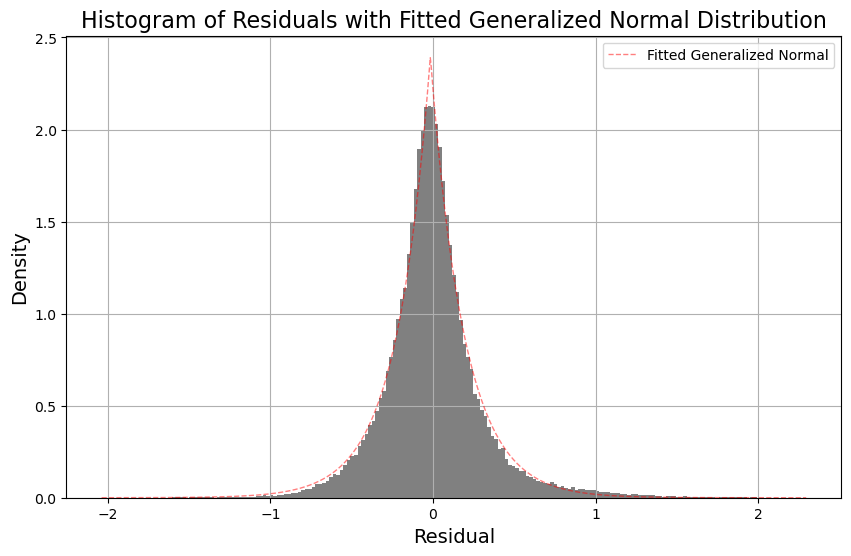

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gennorm, laplace

# Assume that 'preds' and 'actual' have been computed from your validation set.
# For example:
# preds, actual = predict(model, val_loader, device=device)
# Then, compute residuals:
residuals = preds - actual  # The residuals (errors)

# Plot a histogram of the residuals.
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(residuals, bins=201, density=True, alpha=1, color='grey')

# Create an array of x-values spanning the range of residuals.
x = np.linspace(bins[0], bins[-1], 1000)
# Fit a generalized normal distribution to the residuals.
# The gennorm distribution has three parameters: shape (beta), location (loc), and scale.
# shape, loc, scale = gennorm.fit(residuals)  # Fit the distribution
# print("Fitted parameters (shape, loc, scale):", shape, loc, scale)
# pdf_fitted = gennorm.pdf(x, 1, loc=loc, scale=scale)

loc, scale = laplace.fit(residuals)  # Fit the distribution
print("Fitted parameters (shape, loc, scale):", loc, scale)
pdf_fitted = laplace.pdf(x, loc=loc, scale=scale)

# Plot the fitted PDF over the histogram.
plt.plot(x, pdf_fitted, 'r--', linewidth=1, alpha = 0.5, label='Fitted Generalized Normal')
plt.xlabel("Residual", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Histogram of Residuals with Fitted Generalized Normal Distribution", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()